# Testing different implementations of randomisation in `Moran_Local`

In [1]:
from importlib import reload
import esda
import libpysal as ps
import geopandas
import pandas
import numpy as np

PERMS = 9999

from libpysal.examples import get_path, load_example

In [4]:
_ = load_example("NCOVR")

nat = geopandas.read_file(get_path("NAT.shp"))

- Load up data

In [2]:
y_name = "HR70"
#y_name = "HOVAL"
db = geopandas.read_file(get_path("NAT.shp"))

w = ps.weights.Queen.from_dataframe(db)
cardinalities = pandas.Series(w.cardinalities).values

## LISA conditional randomisation

- Example with "as is" codebase:

In [3]:
lisa_old = esda.Moran_Local(db[y_name], w, permutations=PERMS)

In [4]:
# Proper timing
%timeit lisa_old = esda.Moran_Local(db[y_name], w, permutations=PERMS)

3.25 s ± 62.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


- `numba` hooked up on `Moran_Local`. Parallel.

In [5]:
n_jobs = 2
lisa = esda.Moran_Local(db[y_name], w, permutations=PERMS, 
                        numba=True, n_jobs=n_jobs)
%timeit lisa = esda.Moran_Local(db[y_name], w, permutations=PERMS, \
                                numba=True, n_jobs=n_jobs)

The slowest run took 5.22 times longer than the fastest. This could mean that an intermediate result is being cached.
3.62 s ± 1.15 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


- Comparison of P-values

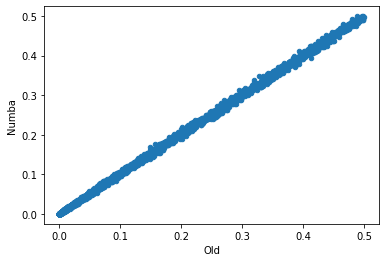

In [6]:
pandas.DataFrame({"Old": lisa_old.p_sim,
                  "Numba": lisa.p_sim
                 }).plot.scatter("Old", "Numba")

- `numba` hooked up on `Moran_Local`. Single thread.

In [7]:
reload(esda.moran)
lisa = esda.Moran_Local(db[y_name], w, permutations=PERMS, numba=True)
%timeit lisa = esda.Moran_Local(db[y_name], w, permutations=PERMS, numba=True)

515 ms ± 47.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


---

In [8]:
import pygeoda

db_geoda = pygeoda.open(get_path("NAT.shp"))
y = db_geoda.GetIntegerCol(y_name)
w_geoda = pygeoda.weights.queen(db_geoda)

In [10]:
%timeit lisa_geoda = pygeoda.local_moran(w_geoda, y)
lisa_geoda = pygeoda.local_moran(w_geoda, y)
lisa_geoda.SetPermutations(9999)
%timeit lisa_geoda.Run()

285 ms ± 12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.88 s ± 35.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


---

- Example with `neighbors_perm_plus`

In [22]:
reload(esda)
acc, out = esda.moran.neighbors_perm_plus(lisa.z, 
                                     lisa.Is, 
                                     cardinalities, 
                                     w.sparse.data,
                                     PERMS,
                                     False
                                    )
%timeit acc, out = esda.moran.neighbors_perm_plus(lisa.z, lisa.Is, cardinalities, w.sparse.data, PERMS, False)

420 µs ± 24.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Permutation index generator

- Original implementation

In [11]:
nn = w.n - 1
k = cardinalities.max() + 1
prange = list(range(PERMS))

In [12]:
%timeit rids = np.array([np.random.permutation(nn)[0:k] for i in prange])

2.48 ms ± 9.43 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


- Levi `numba`

In [13]:
rids = esda.moran.vec_permutations(nn, k)
%timeit rids = esda.moran.vec_permutations(nn, k)

90.4 µs ± 422 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [18]:
r = 0.00248 / 0.0000904
print(f"Speed up of {np.round(r, 2)}x using numba")

Speed up of 27.43x using numba
